In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    
    #k_indices already made 
    # get k'th subgroup in test, others in train: TODO
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1) #reshaping figured out by np
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    
    # ***************************************************
    # form data with polynomial degree: TODO
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    # ***************************************************
    # ridge regression: TODO
    w_opt = ridge_regression(y_tr, tx_tr, lambda_)
    
    # calculate the loss for train and test data: TODO
    loss_tr = np.sqrt(2*compute_mse(y_tr, tx_tr, w_opt)) 
    loss_te = np.sqrt(2*compute_mse(y_te, tx_te, w_opt)) 
    
    return loss_tr, loss_te

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 12
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []

    # cross validation : fold by fold
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range (k_fold): #calculate for every fold as test 
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

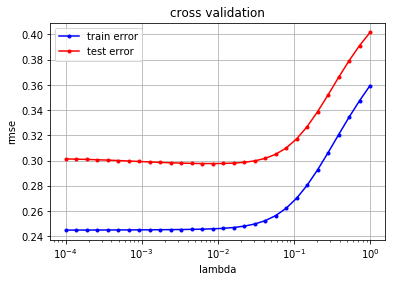

In [6]:
cross_validation_demo()

In [7]:
from plots import *

def cross_validation_degree():
    seed = 1
    lambdas = np.logspace(-4, 0, 30)
    k_fold = 4
    degrees = np.arange(2,11)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    best_lambdas=[]
    best_rmse=[]
    # cross validation : fold by fold
    for degree in degrees: #for every degree we do cross validation
        rmse_te = []
        for lambda_ in lambdas: #cross validation
            rmse_te_tmp = []
            for k in range (k_fold): #calculate for every fold as test 
                _, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
                rmse_te_tmp.append(loss_te)
            rmse_te.append(np.mean(rmse_te_tmp)) #all the rmse for a given lambda
        
        #argmin = return indice of the smallest element in an array 
        ind_lambda_opt = np.argmin(rmse_te) #min rmse indice for given degree
        best_lambdas.append(lambdas[ind_lambda_opt]) #lambda corresponding 
        best_rmse.append(rmse_te[ind_lambda_opt]) #rmse corresponding 
            
    cross_validation_degree_visualization(degrees, best_rmse)
    return degrees[np.argmin(best_rmse)] #degree corresponding to smallest rmse // all degrees 

7


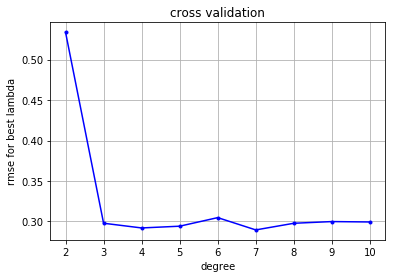

In [8]:
degree = cross_validation_degree()
print(degree)

for bonus : instead of taking the mean : we add the all table of tmp rmse so we have a matrix of all the different tables and then when plotting : plot the box plot of the tmp (distribution). 

In [9]:
def extended_cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    variances = []
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(rmse_tr_tmp)
        rmse_te.append(rmse_te_tmp)
        variances.append(loss_te)

    plt.boxplot(rmse_te)

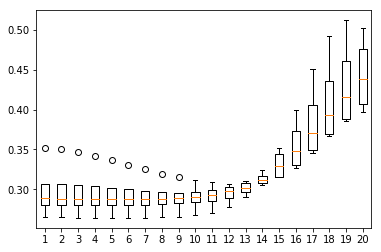

In [10]:
extended_cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

In [13]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        # ***************************************************
        # bias_variance_decomposition
        #need error vs degree 
        for index_degree, degree in enumerate(degrees): 
            # form data with polynomial degree
            tx_tr = build_poly(x_tr, degree)
            tx_te = build_poly(x_te, degree)
            #use least squares method to obtain optimal w 
            w = least_squares(y_tr, tx_tr)
            
            rmse_tr[index_seed, index_degree] = np.sqrt(2*compute_mse(y_tr, tx_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(2*compute_mse(y_te, tx_te, w))
        
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

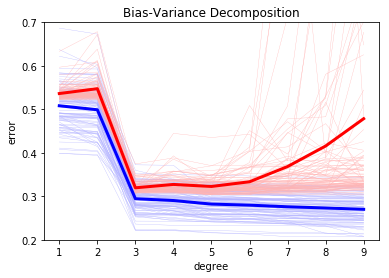

In [14]:
bias_variance_demo()